In [1]:
%load_ext autoreload
%autoreload 2

from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import glint_angle

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44979,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:44461,Total threads: 62
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/39623/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:41159,


In [11]:
import odc.geo.xr
import datacube
from odc.algo import to_float

dc = datacube.Datacube()

t, l = -21.682716, 149.352524
b, r = -22.696081, 150.082148


# t, l = -19.278743, 147.335721
# b, r = -19.805393, 147.686853


t, l = -13.12801, 129.96552
b, r = -13.53226, 130.35755

# ds = dc.load(product=["ga_ls8c_ard_3", "ga_ls9c_ard_3"], **query_params, **load_params)
# ds = to_float(ds)
# ds = load_ard(dc=dc, products=["ga_ls8c_ard_3", "ga_ls9c_ard_3"], **load_params, **query_params)
# ds


spectral_bands = ["nbart_red", "nbart_green", "nbart_nir"]

sunglint_bands = [
    "oa_solar_zenith",
    "oa_solar_azimuth",
    "oa_satellite_azimuth",
    "oa_satellite_view",
]

query_params = dict(x=(l, r), y=(t, b), time=("2013", "2023"))

load_params = dict(
    measurements=spectral_bands + sunglint_bands,
    dask_chunks={"x": 2048, "y": 2048},
    resolution=(-50, 50),
    cloud_cover=(0, 80),
    resampling="average",
    mask_filters=[("dilation", 5)]
)


ds = load_ard(
    dc=dc, products=["ga_ls8c_ard_3", "ga_ls9c_ard_3"], **load_params, **query_params
)

# ds.persist()

Finding datasets
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Applying morphological filters to pixel quality mask: [('dilation', 5)]
Applying fmask pixel quality/cloud mask
Returning 439 time steps as a dask array


/env/lib/python3.10/site-packages/dea_tools/datahandling.py:492: UserWarning: As of `dea_tools` v0.3.0, pixel quality masks are inverted before being passed to `mask_filters` (i.e. so that good quality/clear pixels are False and poor quality pixels/clouds are True). This means that 'dilation' will now expand cloudy pixels, rather than shrink them as in previous versions.
  warnings.warn(


In [12]:
ndti = (ds.nbart_red - ds.nbart_green) / (ds.nbart_red + ds.nbart_green)
ndwi = (ds.nbart_green - ds.nbart_nir) / (ds.nbart_green + ds.nbart_nir)

In [13]:
# Calculate glint angle using sensor and solar geometry
glint_array = glint_angle(
    solar_azimuth=ds.oa_solar_azimuth,
    solar_zenith=ds.oa_solar_zenith,
    view_azimuth=ds.oa_satellite_azimuth,
    view_zenith=ds.oa_satellite_view,
)

In [14]:
ndti_seasonal = ndti.where((ndwi > 0) & (glint_array > 20)).groupby("time.season").mean()

In [15]:
ndti_seasonal.load()

<xarray.DataArray (season: 4, y: 895, x: 875)>
array([[[-0.31761315, -0.31622833, -0.3143948 , ...,         nan,
                 nan,         nan],
        [-0.3205547 , -0.31834662, -0.317528  , ...,         nan,
                 nan,         nan],
        [-0.3208815 , -0.3195407 , -0.31284013, ...,         nan,
                 nan,         nan],
        ...,
        [-0.07221989, -0.07034399, -0.06905635, ...,         nan,
                 nan,         nan],
        [-0.05958224, -0.05761545, -0.05702563, ...,         nan,
                 nan,         nan],
        [-0.07801304, -0.06111889, -0.06335668, ...,         nan,
                 nan,         nan]],

       [[-0.4209929 , -0.42019263, -0.42085093, ...,         nan,
                 nan,         nan],
        [-0.4193306 , -0.4185119 , -0.41956806, ...,         nan,
                 nan,         nan],
        [-0.42125696, -0.4162945 , -0.41811094, ...,         nan,
                 nan,         nan],
...
        [-0.1782606 , -0.17575595, -0.16964005, ...,         nan,
                 nan,         nan],
        [-0.16391231, -0.16809627, -0.16510609, ...,         nan,
                 nan,         nan],
        [-0.15874325, -0.15596327, -0.1561282 , ...,         nan,
                 nan,         nan]],

       [[-0.33755127, -0.3358004 , -0.33578464, ...,         nan,
                 nan,         nan],
        [-0.33495468, -0.33740017, -0.33733666, ...,         nan,
                 nan,         nan],
        [-0.3350927 , -0.33725914, -0.3394812 , ...,         nan,
                 nan,         nan],
        ...,
        [-0.09261575, -0.08997951, -0.09311423, ...,         nan,
                 nan,         nan],
        [-0.06116478, -0.06060295, -0.06375739, ...,         nan,
                 nan,         nan],
        [-0.04798657, -0.04710419, -0.04454995, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 -1.388e+06 -1.388e+06 ... -1.433e+06 -1.433e+06
  * x            (x) float64 -2.24e+05 -2.239e+05 ... -1.803e+05 -1.803e+05
    spatial_ref  int32 3577
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [16]:
# ndti_seasonal.plot.imshow(col="month", col_wrap=4, vmin=-0.5, vmax=0.0, cmap="magma")

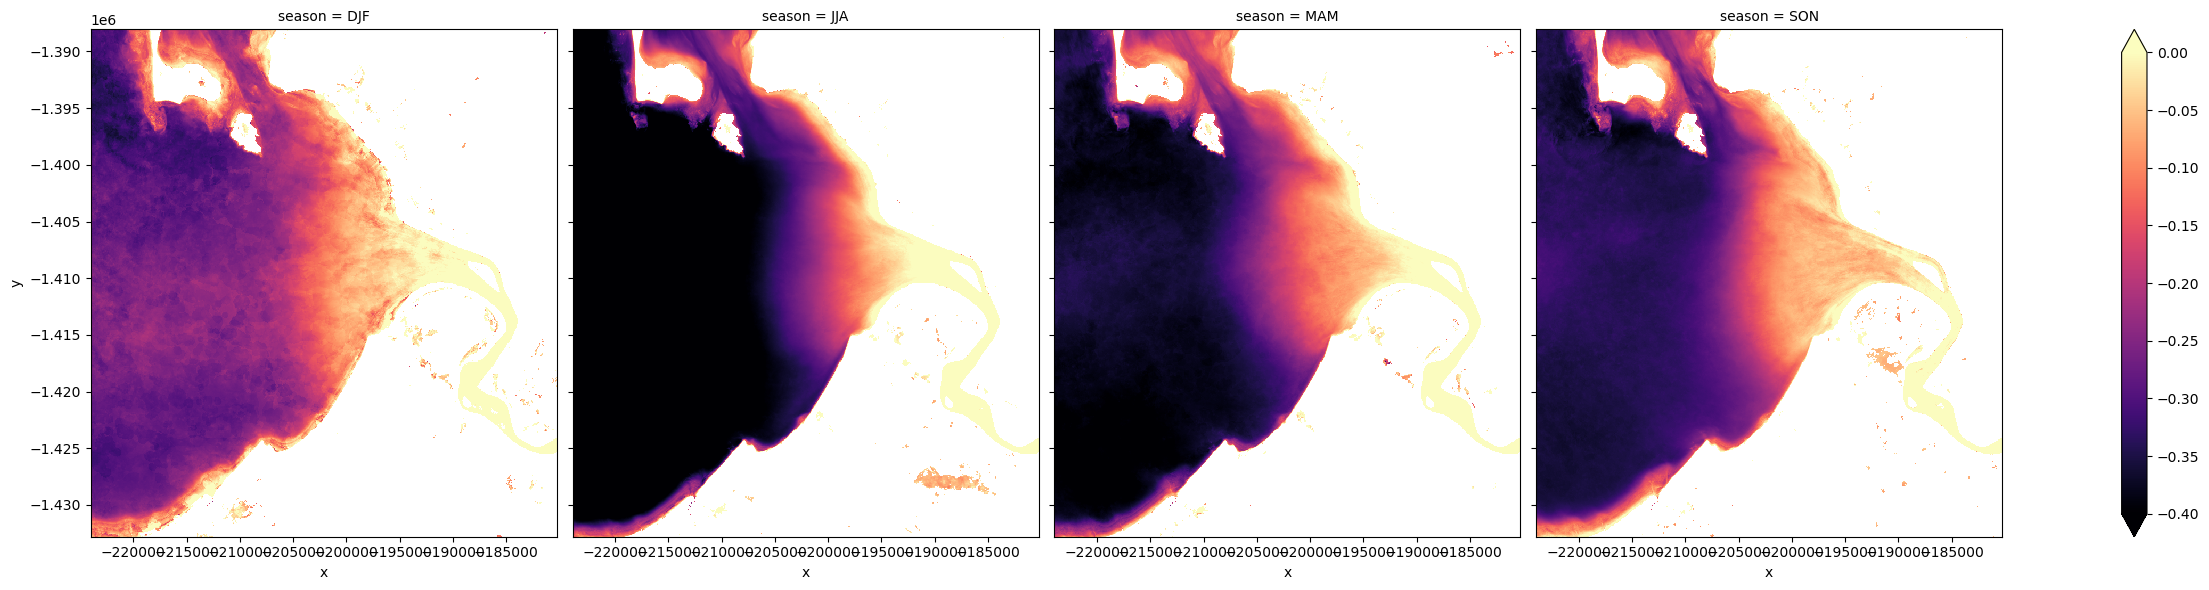

In [17]:
ndti_seasonal.plot.imshow(col="season", col_wrap=4, size=6, vmin=-0.4, vmax=0.0, cmap="magma")

In [ ]:
# import matplotlib.pyplot as plt
# plt.imsave("nt_dry.png", ds_monthly.odc.to_rgba(bands=["nbart_common_swir_2", "nbart_common_nir", "nbart_green"], vmin=0, vmax=3000).data)